# ... And They Will Come!

## OpenStreetMap road network analysis in Python

Eberhard Hansis @ Geomob Meetup Munich, September 2019

# Goals of this notebook
## (1) Introduce you to OpenStreetMap data
## (2) Show that GIS-like work can be done in Python
## (3) Find somebody to market these plots! ;-)

In [22]:
# imports (more imports below, these are the 'boring' ones only)
import json
import math
from IPython.display import IFrame, Image
import pickle
from matplotlib import pyplot

%matplotlib inline

# don't show warnings
import warnings
warnings.filterwarnings('ignore')

We want to make a graph similar to the image in the next cell. 

The idea behind it is as follows: We query all roads inside a certain radius around a target location. Then we assume that everyone living along these roads travels to the target location, along their respective shortest path (with respect to travel time). The graph shows the flow of people, with thicker lines indicating more people traveling along a road segment.

So what we will do is:
- Query road data from OpenStreetMaps
- Assign max speeds to road types
- Compute shortest paths
- Generate the plot

This notebook explains the basic process behind the graph generation. To get a nice image as the one shown below, some additional steps are necessary and a different plotting mechanism is used (via LaTeX and Tikz). This is not part of the notebook, so the final result shown here will look different.

The analysis done below is not very accurate, there are numerous possibilities for improvement. For example, the allowed speed should be varied by road type, if not given, and max speeds on unlimited highways should be set to a high value like 130 km/h.

Also, the graph below was made with a 14 km plot radius, while we will use a smaller radius here, to reduce the amount of data that's queried and processed.

In [2]:
IFrame("rev_e25b389e_tex_spd_14.000000_11.608344_48.124175.pdf", width=800, height=800)

# Setup

In [3]:
# Werk 1, Munich
target_coords = dict(lat=48.124175, lon=11.608344)

# radius for plot
radius_km = 5.  

osm_data_file_name = "output/osm_roads.json"
graph_file_name = "output/graph.pickle"
graph_simplified_file_name = "output/graph_simplified.pickle"
path_file_name = "output/paths.pickle"
plot_file_name = "output/plot.png"

# Query data from OpenStreetMaps

- Easiest interface: Overpass Turbo http://overpass-turbo.eu/
- Has a nice wizard to help query building
- Try this in the wizard: `shop=bakery in Munich` &nbsp;&nbsp; <span style='color: green'>&#9658; Demo</span>


# Define the query

In [4]:
# compute bounding box size in degrees
# constants are km per degree lon/lat
bbox_lon_radius = radius_km / 71.5 * 1.2
bbox_lat_radius = radius_km / 111.2 * 1.2

# compute bounding box
lat_min = target_coords['lat'] - bbox_lat_radius
lon_min = target_coords['lon'] - bbox_lon_radius
lat_max = target_coords['lat'] + bbox_lat_radius
lon_max = target_coords['lon'] + bbox_lon_radius

overpass_query = f"""
[out:json][timeout:60];
(
  way["highway"~"motorway|motorway_link|primary|trunk|trunk_link|primary_link|
                 secondary|secondary_link|tertiary|tertiary_link|
                 unclassified|residential|living_street"]
  ({lat_min}, {lon_min}, {lat_max}, {lon_max});
);
out body;
>;
out skel qt;
"""

# Run the query

In [5]:
import requests

print("Querying...")
response = requests.post(
    'http://overpass-api.de/api/interpreter', 
    data=overpass_query)
print(response.status_code)

print("Saving...")
with open(osm_data_file_name, 'w') as f:
    f.write(response.text)

Querying...
200
Saving...


# OpenStreetMap Data Example (JSON Format)

## Nodes
```
...
{
  "type": "node",
  "id": 31389989,
  "lat": 48.0910291,
  "lon": 11.5592603
},
{
  "type": "node",
  "id": 32342804,
  "lat": 48.0934394,
  "lon": 11.5601820
},
...
```

<img src='img/node_31389989.jpg'/>

## Ways
```
...
{
  "type": "way",
  "id": 706305967,
  "nodes": [
    11310367,
    6636763168,
    618702499
  ],
  "tags": {
    "highway": "residential",
    "lanes": "2",
    "maxspeed": "50",
    "name": "Luisenstraße",
    "sidewalk": "both",
    "surface": "asphalt"
  }
},
...
```

## Relations (not used here)

<img src='img/way_706305967.jpg'/>

# Let's build a road network graph

<img src='https://networkx.github.io/documentation/stable//tutorial-34.png'/>

In [6]:
# coordinate transformation from degrees lat/lon to meters (valid for Europe)

import pyproj

in_proj = pyproj.Proj(init='epsg:4326')    # see: https://epsg.io/4326
out_proj = pyproj.Proj(init='epsg:25832')  # see: https://epsg.io/25832

target_x, target_y = pyproj.transform(
    in_proj, out_proj, 
    target_coords['lon'], target_coords['lat'])

print(target_x, target_y)

694096.1233610448 5333392.628505349


In [7]:
# load the queried road data
with open(osm_data_file_name) as f:
    data = json.load(f)

# create an empty graph
import networkx
g = networkx.Graph()
nodes = dict()
ways = dict()

In [8]:
# parse all nodes
closest_node = None
closest_dist = 1.e6
for el in data['elements']:
    if el['type'] == 'node':
        node_id = int(el['id'])
        
        # project to meters
        x, y = pyproj.transform(in_proj, out_proj, el['lon'], el['lat'])
        
        # distance to target coordinates (meters)
        d = math.sqrt((x - target_x)**2 + (y - target_y)**2) 
        
        # add nodes in our circular plot region only
        if d < radius_km * 1000:
            g.add_node(node_id, x=x, y=y, d=d)

            # determine node ID closest to target
            if d < closest_dist:
                closest_node = node_id
                closest_dist = d

In [9]:
print(closest_dist)
print(closest_node)

127.52396334562911
3963501744


In [10]:
# parse ways, assign speeds
for el in data['elements']:
    if el['type'] == 'way':
        
        # this iterates over pairs of consecutive nodes node1, node2
        for node_id_1, node_id_2 in zip(el['nodes'][:-1], el['nodes'][1:]):
            
            # only add a way if the nodes are part of our graph
            if node_id_1 in g.node and node_id_2 in g.node:

                # compute segment length (in meters)
                n1 = g.node[node_id_1]
                n2 = g.node[node_id_2]
                s = math.sqrt((n1['x'] - n2['x']) ** 2 + (n1['y'] - n2['y']) ** 2)

                # use max speed from OpenStreetMaps if possible, 50 km/h else
                try:
                    v = float(el['tags'].get('maxspeed', '50'))
                except ValueError:
                    # Value Error is raised if maxspeed cannot be 
                    # interpreted as float, e.g. 'walk'
                    v = 50
                
                # convert from km/h to m/s
                v = v / 3600 * 1000

                # compute travel time along the segment, store new edge in graph
                g.add_edge(node_id_1, node_id_2, s=s, t=s / v, flow=0)

In [11]:
# store the graph
with open(graph_file_name, 'wb') as f:
    pickle.dump((g, closest_node), f)

# That's a pretty big graph!

In [12]:
# number of nodes
print(len(g.nodes()))

23248


In [13]:
print(len(g.edges()))

24397


# Network Analysis

The networkx library offers a large number of algorithms, e.g.
- Shortest paths
- Clustering
- Connected components
- Flows

# Compute shortest paths (w.r.t. travel time)

In [14]:
# load our network graph
with open(graph_file_name, 'rb') as f:
    g, target_node = pickle.load(f)

# compute shortest paths from any node to our target node
distances, paths = networkx.single_source_dijkstra(g, target_node)

# Example shortest path

In [15]:
source_id = 673918548

# travel time, in minutes, from some random node ID
print(distances[source_id] / 60)

1.8666666666666667


In [16]:
# first 10 nodes along the shortest path from that node ID
print(paths[source_id][:10])

[3963501744, 6426659931, 6426659936, 4401084594, 5739075424, 4401460725, 294225140, 13876332, 294225138, 1991963051]


In [17]:
# total number of nodes along the path
print(len(paths[source_id]))

113


# Aggregate flow on each edge

In [18]:
# flow = the number of shortest paths passing through each edge
for source_id, path in paths.items():
    # again, iterate over pairs of consecutive nodes along the path
    for m1, m2 in zip(path[:-1], path[1:]):
        # increment the flow on the respective edge
        g.adj[m1][m2]['flow'] += 1

# store graph
with open(path_file_name, 'wb') as f:
    pickle.dump((g, target_node), f)

# Create the plot!

In [19]:
# load the graph
with open(path_file_name, 'rb') as f:
    g, target_node = pickle.load(f)
    
# extract desired properties: x/y locations of nodes, flow for scaling edge widths
node_pos = {n: (g.nodes[n]['x'], g.nodes[n]['y']) for n in g.nodes()}
flow = [math.log(1 + g.adj[u][v].get('flow', 0) / 3) for u, v in g.edges()]

In [20]:
# prepare figure
fig = pyplot.figure(figsize=(8, 8))
ax = pyplot.subplot(111)
ax.axis('off')

# plot the edges
networkx.draw_networkx_edges(g, pos=node_pos, width=flow)

# plot the center
ax.plot(target_x, target_y, 'ro', markersize=20)

# set plot limits
plot_radius_m = radius_km * 1000
ax.set_xlim([target_x - plot_radius_m, target_x + plot_radius_m])
ax.set_ylim([target_y - plot_radius_m, target_y + plot_radius_m])

# save
pyplot.savefig(plot_file_name)
pyplot.close()

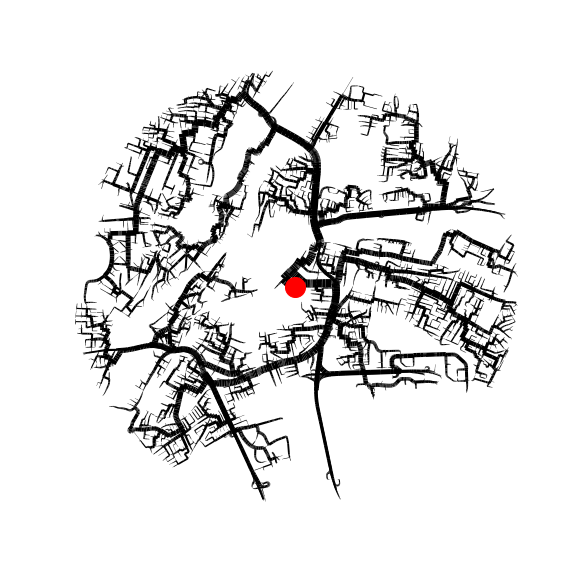

In [23]:
Image("output/plot.png")

## Required Packages

* requests (HTTP request handling)
* networkx (graph analysis, https://networkx.github.io/documentation/stable/)
* pyproj (map projections, http://pyproj4.github.io/pyproj/stable/)

## Helpful packages (not used here)
* geopandas (awesome geospatial data analysis lib, http://geopandas.org/)

## Helpful links
* OpenStreetMap ID Editor: contribute, see detailed data (https://wiki.openstreetmap.org/wiki/ID)

# Thank You

### Find this notebook at: https://github.com/ehansis/theywillcome

Eberhard Hansis, Vebeto GmbH, www.vebeto.de

eberhard.hansis@vebeto.de

<img src='https://www.vebeto.de/img/vebeto_green_blue_bm.svg'/>